In [6]:
import datetime
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import os
import json
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import widgets
from IPython.display import display, Image, clear_output
from ipywidgets import interact, interactive, fixed, interact_manual

#Folder of a given season 
file_path='/Users/ceciliaacosta/Desktop/nhl_data/20192020'
#Path to the rink image
rink_image_path='/Users/ceciliaacosta/Desktop/nhl_data/nhl_rink.png'
year=file_path[-8:-4]

# Get the total number and the ID's to use in the slider (LAST FOUR DIGITS) of regular season and playoff games
regular_games=[filename for filename in (os.listdir(file_path)) if filename[-11:-9]=='02']
total_regular_season_games = len(regular_games)
idx_regular_games=sorted([int(id.rstrip('.json')[-4:]) for id in regular_games])

playoff_games = [filename for filename in (os.listdir(file_path)) if  filename[-11:-9]=='03']
total_playoff_games=len(playoff_games)
idx_playoff_games=sorted([int(id.rstrip('.json')[-3:]) for id in playoff_games])



In [7]:
def get_coordinates(nested_data, event_id):
    
    x=nested_data[event_id].get('coordinates').get('x',None)
    y=nested_data[event_id].get('coordinates').get('y',None)

    return x, y 

#load data
def load_data(game_ID, season):
    global file_path
    if season=='regular_season':
        season_code='02'
    else:
        season_code='03'

    if len(str(game_ID))==1:
        files_game = f"{file_path}/nhl_game_{year}{season_code}000{game_ID}.json"
    if len(str(game_ID))==2:
        files_game = f"{file_path}/nhl_game_{year}{season_code}00{game_ID}.json"
    if len(str(game_ID))==3:
        files_game = f"{file_path}/nhl_game_{year}{season_code}0{game_ID}.json"
    if len(str(game_ID))==4:
        files_game = f"{file_path}/nhl_game_{year}{season_code}{game_ID}.json"

    if os.path.exists(files_game):

        with open(files_game, 'r') as file:
            return json.load(file)
    else:
        return None

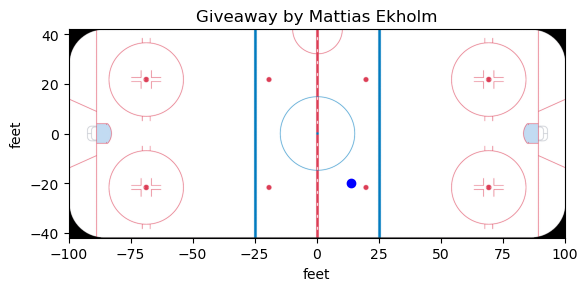

{'about': {'dateTime': '2019-10-20T01:15:41Z',
           'eventId': 309,
           'eventIdx': 128,
           'goals': {'away': 0, 'home': 0},
           'ordinalNum': '2nd',
           'period': 2,
           'periodTime': '10:44',
           'periodTimeRemaining': '09:16',
           'periodType': 'REGULAR'},
 'coordinates': {'x': 14.0, 'y': -20.0},
 'players': [{'player': {'fullName': 'Mattias Ekholm',
                         'id': 8475218,
                         'link': '/api/v1/people/8475218'},
              'playerType': 'PlayerID'}],
 'result': {'description': 'Giveaway by Mattias Ekholm',
            'event': 'Giveaway',
            'eventCode': 'NSH309',
            'eventTypeId': 'GIVEAWAY'},
 'team': {'id': 18,
          'link': '/api/v1/teams/18',
          'name': 'Nashville Predators',
          'triCode': 'NSH'}}


In [ ]:
# Create a dropdown widget to select the season
season_dropdown = widgets.Dropdown(
    options=['Regular Season', 'Playoffs'],
    description='Season:',
)

#Create an IntSlider for Game ID with a maximum value that depends on the selected season
game_id_slider = widgets.IntSlider(
    min=1,
    max=total_regular_season_games,
    description='Game ID:',
    continuous_update=False,
    options=idx_regular_games
)

event_id_slider = widgets.IntSlider(
    min=0,
    max=0,  # Initialize with 0 events
    description='Event ID:',
    continuous_update=False,
)

In [9]:
display(season_dropdown, game_id_slider, event_id_slider)

Dropdown(description='Season:', options=('Regular Season', 'Playoffs'), value='Regular Season')

IntSlider(value=1, continuous_update=False, description='Game ID:', max=1082, min=1)

IntSlider(value=0, continuous_update=False, description='Event ID:', max=0)

In [10]:
output = widgets.Output()
def display_game_events(game_data):

    allplays_path=['liveData', 'plays', 'allPlays']
    nested_data = game_data

    #Update the event ID slider (aka the index in the list of events)
    for key in allplays_path:
        nested_data = nested_data.get(key, {})
    event_id_slider.max=len(nested_data)-1
    event_id = event_id_slider.value
    # with output:
    #     clear_output(wait=True)
    clear_output(wait=True)

    if game_data:
        x_coord, y_coord=get_coordinates(nested_data, event_id)
        if x_coord== None and y_coord==None:
            pprint(nested_data[event_id])
            event_type=nested_data[event_id].get('result',{}).get('description',"")
        else:
            event_type=nested_data[event_id].get('result',{}).get('description',"")
# Display event information on the ice rink image
            # Load the rink image to get its dimensions
            rink_image = mpimg.imread(rink_image_path)
            fig, ax = plt.subplots()
            ax.patch.set_facecolor('black')
            im = ax.imshow(rink_image, origin='lower', extent=[-100, 100, -42, 42])
            ax.plot(x_coord,y_coord, 'bo')
            ax.set_title(f'{event_type}')
            ax.set_xlabel('feet')
            ax.set_ylabel('feet')
            plt.show()
            pprint(nested_data[event_id])

    # Function to update the display based on the selected season and game ID
def update_display(change):
    season = 'regular_season' if season_dropdown.value == 'Regular Season' else 'playoffs'
    game_id = game_id_slider.value
    game_data = load_data(game_id, season)

    if game_data:
        display_game_events(game_data)

    else:

        print(f"Game data not found for Game ID {game_id} in the {season}.")


#Function to update the slider based on the selected type of Season 
def update_slider(change):
    if season_dropdown.value == 'Regular Season':
        game_id_slider.max = max(idx_regular_games)
        game_id_slider.min = min(idx_regular_games)
        game_id_slider.options=idx_regular_games

    else:
        game_id_slider.max = max(idx_playoff_games)
        game_id_slider.min= min(idx_playoff_games)
        game_id_slider.options=idx_playoff_games

# Attach the update_display function to the widgets' observe methods
season_dropdown.observe(update_slider, 'value')
game_id_slider.observe(update_display, 'value')
event_id_slider.observe(update_display, 'value')

display(output)


Output()